<a href="https://colab.research.google.com/github/Pravinoraon/deeplearning-object-detection/blob/main/Resnet50train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Use GPU strategy for T4 GPU
strategy = tf.distribute.MirroredStrategy()  # This is for multi-GPU or single GPU setup

print("Number of devices:", strategy.num_replicas_in_sync)

Number of devices: 1


In [5]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 32
EPOCHS = 10

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

In [6]:
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/classification_data/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    "/content/drive/MyDrive/classification_data/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 9863 images belonging to 32 classes.
Found 2482 images belonging to 32 classes.


In [7]:
# Load Pretrained ResNet50
with strategy.scope():  # Ensure the model is built within the strategy scope
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # Unfreeze for fine-tuning

    # Freeze first few layers to speed up and stabilize training
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Add custom classifier head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)


In [9]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 4372s 14s/step - accuracy: 0.3279 - loss: 2.4377 - val_accuracy: 0.6700 - val_loss: 1.0855 - learning_rate: 1.0000e-04
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 3961s 13s/step - accuracy: 0.7258 - loss: 0.9450 - val_accuracy: 0.8070 - val_loss: 0.6643 - learning_rate: 1.0000e-04
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 3960s 13s/step - accuracy: 0.8413 - loss: 0.5538 - val_accuracy: 0.9371 - val_loss: 0.2318 - learning_rate: 1.0000e-04
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 3945s 13s/step - accuracy: 0.8778 - loss: 0.4257 - val_accuracy: 0.9073 - val_loss: 0.3156 - learning_rate: 1.0000e-04
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 3967s 13s/step - accuracy: 0.9174 - loss: 0.2834 - val_accuracy: 0.9408 - val_loss: 0.1775 - learning_rate: 1.0000e-04
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 3922s 13s/step - accuracy: 0.9186 - loss: 0.2664 - val_accuracy: 0.9287 - val_loss: 0.2453 - learning_rate: 1.0000e-04
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 3928s 

In [10]:
# Save final model
model.save("/content/drive/MyDrive/object_classification_model.h5")
print("✅ New model trained and saved! You can replace the old .h5 file now.")


✅ New model trained and saved! You can replace the old .h5 file now.


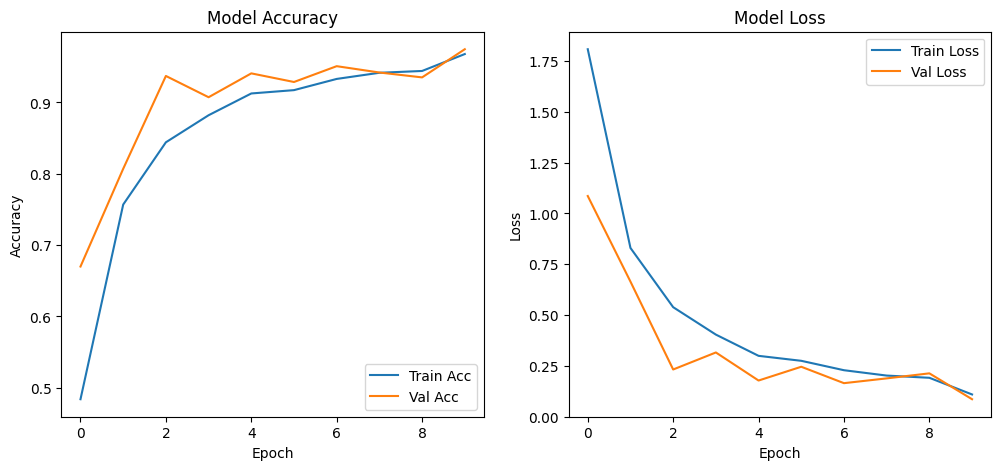

In [11]:
# Plot training results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()